# 🩺 Sepsis Prediction from Clinical Time-Series Data

**Course**: Healthcare Information Systems  
**Team Members**: Pallavi Rajan, Ardak Baizhaxynova, Santiago Enriquez Benavides  
**Andrew IDs**: prajan, abaizhax, ienrique  
**Date**: April 2025  

---

## Project Overview

This project aims to develop a **Decision Support System (DSS)** that integrates a machine learning model to provide an **hourly Sepsis Risk Score** for hospitalized patients. The system is designed to assist healthcare professionals in identifying sepsis in its early stages, thereby enabling timely interventions and improving patient outcomes.

We utilize the publicly available [Kaggle Sepsis Prediction Dataset](https://www.kaggle.com/datasets/salikhussaini49/prediction-of-sepsis), which contains de-identified time-series clinical data for thousands of patients.

---

## Notebook Structure

1. **Importing Libraries**  
2. **Initial Review of the Data and Formatting**  
3. **Handling Missing Data**  
4. **Exploratory Data Analysis (EDA)**
5. **Balancing Dataset**
6. **Additional EDA on balanced dataset**
7. **Modeling and Validation**  
8. **Feature Importance Analysis**  
9. **Sensitivity Analysis**

---


## 1. Packages to Import

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.2 MB/s eta 0:00:00


In [ ]:
# Core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and transformation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Model selection and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report, accuracy_score, recall_score,
    precision_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    ExtraTreesClassifier, AdaBoostClassifier
)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV

# Gradient boosting alternatives
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# SHAP for model explainability
import shap

# Matplotlib compatibility
import matplotlib


In [ ]:
# read the csv file and load to a dataframe
file = "Original_Sepsis_data.csv"
df = pd.read_csv(file)

Mounted at /content/drive/
/content/drive/My Drive/Sepsis data original


## 2. Initial Review of the Data and Formatting

### Objective
The goal of this section is to conduct an initial inspection of the dataset to understand its structure, variables, and baseline distribution for the sepsis prediction task.

### Variable Summary
- **Initial Independent Variables**: 35 unique clinical and demographic features measured hourly per patient.
- **Initial Dependent Variable**: `SepsisIndicator` (binary classification: 1 = Sepsis, 0 = No Sepsis).
- **Final Target Representation**: A predicted **Sepsis Risk Score** (continuous probability ranging from 0 to 1), derived from model output.

### Key Observations
- Each row in the dataset corresponds to **one hour of observation** for a given patient.
- **Column names** were renamed for clarity and consistency with clinical terminology.
- **Descriptive analysis** showed that vital signs and lab results have a wide range, with common clinical values such as heart rate, blood pressure, and oxygen saturation exhibiting typical physiological variability. Summary statistics confirmed the presence of outliers, likely reflecting true clinical extremes or data entry errors.
- The **baseline proportion of sepsis-positive and negative patients** is approximately **2% and 98%**, respectively, highlighting the **highly imbalanced nature** of the dataset.

---



In [ ]:
df.head()

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [ ]:
#Calculate the number of rows and columns in the sheet
print(df.shape)
df.dtypes

(1552210, 44)


,0
Unnamed: 0,int64
Hour,int64
HR,float64
O2Sat,float64
Temp,float64
SBP,float64
MAP,float64
DBP,float64
Resp,float64
EtCO2,float64


In [ ]:
#Rename Column names for more userfrinedly appearance
column_mapping = {
    "Unnamed: 0": "CheckID",
    "Hour": "HourOfObservation",
    "HR": "HeartRate",
    "O2Sat": "OxygenSaturation",
    "Temp": "Temperature",
    "SBP": "SystolicBloodPressure",
    "MAP": "MeanArterialPressure",
    "DBP": "DiastolicBloodPressure",
    "Resp": "RespiratoryRate",
    "EtCO2": "EndTidalCO2",
    "BaseExcess": "BaseExcess",
    "HCO3": "Bicarbonate",
    "FiO2": "FractionInspiredOxygen",
    "pH": "pH",
    "PaCO2": "PartialPressureCO2",
    "SaO2": "OxygenSaturationArterial",
    "AST": "AspartateTransaminase",
    "BUN": "BloodUreaNitrogen",
    "Alkalinephos": "AlkalinePhosphatase",
    "Calcium": "CalciumLevel",
    "Chloride": "ChlorideLevel",
    "Creatinine": "CreatinineLevel",
    "Bilirubin_direct": "DirectBilirubin",
    "Glucose": "GlucoseLevel",
    "Lactate": "LactateLevel",
    "Magnesium": "MagnesiumLevel",
    "Phosphate": "PhosphateLevel",
    "Potassium": "PotassiumLevel",
    "Bilirubin_total": "TotalBilirubin",
    "TroponinI": "TroponinI",
    "Hct": "Hematocrit",
    "Hgb": "Hemoglobin",
    "PTT": "PartialThromboplastinTime",
    "WBC": "WhiteBloodCellCount",
    "Fibrinogen": "FibrinogenLevel",
    "Platelets": "PlateletCount",
    "Age": "PatientAge",
    "Gender": "PatientGender",
    "Unit1": "CareUnit1",
    "Unit2": "CareUnit2",
    "HospAdmTime": "TimeSinceHospitalAdmission",
    "ICULOS": "ICULengthOfStay",
    "SepsisLabel": "SepsisIndicator",
    "Patient_ID": "PatientID"
}

df.rename(columns=column_mapping, inplace=True)
print("Renamed Column Names:")
print(df.columns)

Renamed Column Names:
Index(['CheckID', 'HourOfObservation', 'HeartRate', 'OxygenSaturation',
       'Temperature', 'SystolicBloodPressure', 'MeanArterialPressure',
       'DiastolicBloodPressure', 'RespiratoryRate', 'EndTidalCO2',
       'BaseExcess', 'Bicarbonate', 'FractionInspiredOxygen', 'pH',
       'PartialPressureCO2', 'OxygenSaturationArterial',
       'AspartateTransaminase', 'BloodUreaNitrogen', 'AlkalinePhosphatase',
       'CalciumLevel', 'ChlorideLevel', 'CreatinineLevel', 'DirectBilirubin',
       'GlucoseLevel', 'LactateLevel', 'MagnesiumLevel', 'PhosphateLevel',
       'PotassiumLevel', 'TotalBilirubin', 'TroponinI', 'Hematocrit',
       'Hemoglobin', 'PartialThromboplastinTime', 'WhiteBloodCellCount',
       'FibrinogenLevel', 'PlateletCount', 'PatientAge', 'PatientGender',
       'CareUnit1', 'CareUnit2', 'TimeSinceHospitalAdmission',
       'ICULengthOfStay', 'SepsisIndicator', 'PatientID'],
      dtype='object')


In [ ]:
#check the statistics of all columns
df.describe(include="all")

,CheckID,HourOfObservation,HeartRate,OxygenSaturation,Temperature,SystolicBloodPressure,MeanArterialPressure,DiastolicBloodPressure,RespiratoryRate,EndTidalCO2,...,FibrinogenLevel,PlateletCount,PatientAge,PatientGender,CareUnit1,CareUnit2,TimeSinceHospitalAdmission,ICULengthOfStay,SepsisIndicator,PatientID
count,1.552210e+06,1.552210e+06,1.398811e+06,1.349474e+06,525226.000000,1.325945e+06,1.358940e+06,1.065656e+06,1.313875e+06,57636.000000,...,10242.000000,92209.000000,1.552210e+06,1.552210e+06,940250.000000,940250.000000,1.552202e+06,1.552210e+06,1.552210e+06,1.552210e+06
mean,2.549274e+01,2.549274e+01,8.458144e+01,9.719395e+01,36.977228,1.237505e+02,8.240010e+01,6.383056e+01,1.872650e+01,32.957657,...,287.385706,196.013911,6.200947e+01,5.592690e-01,0.496571,0.503429,-5.612512e+01,2.699499e+01,1.798468e-02,5.920148e+04
std,2.888256e+01,2.888256e+01,1.732524e+01,2.936924e+00,0.770014,2.323156e+01,1.634175e+01,1.395601e+01,5.098194e+00,7.951662,...,153.002908,103.635366,1.638622e+01,4.964749e-01,0.499989,0.499989,1.622569e+02,2.900542e+01,1.328956e-01,5.024819e+04
min,0.000000e+00,0.000000e+00,2.000000e+01,2.000000e+01,20.900000,2.000000e+01,2.000000e+01,2.000000e+01,1.000000e+00,10.000000,...,34.000000,1.000000,1.400000e+01,0.000000e+00,0.000000,0.000000,-5.366860e+03,1.000000e+00,0.000000e+00,1.000000e+00
25%,9.000000e+00,9.000000e+00,7.200000e+01,9.600000e+01,36.500000,1.070000e+02,7.100000e+01,5.400000e+01,1.500000e+01,28.000000,...,184.000000,126.000000,5.168000e+01,0.000000e+00,0.000000,0.000000,-4.705000e+01,1.100000e+01,0.000000e+00,9.990000e+03
50%,1.900000e+01,1.900000e+01,8.350000e+01,9.800000e+01,37.000000,1.210000e+02,8.000000e+01,6.200000e+01,1.800000e+01,33.000000,...,250.000000,181.000000,6.400000e+01,1.000000e+00,0.000000,1.000000,-6.030000e+00,2.100000e+01,0.000000e+00,1.996500e+04
75%,3.300000e+01,3.300000e+01,9.550000e+01,9.950000e+01,37.500000,1.380000e+02,9.200000e+01,7.200000e+01,2.150000e+01,38.000000,...,349.000000,244.000000,7.400000e+01,1.000000e+00,1.000000,1.000000,-4.000000e-02,3.400000e+01,0.000000e+00,1.098780e+05
max,3.350000e+02,3.350000e+02,2.800000e+02,1.000000e+02,50.000000,3.000000e+02,3.000000e+02,3.000000e+02,1.000000e+02,100.000000,...,1760.000000,2322.000000,1.000000e+02,1.000000e+00,1.000000,1.000000,2.399000e+01,3.360000e+02,1.000000e+00,1.200000e+05


SepsisIndicator
0    0.982015
1    0.017985
Name: proportion, dtype: float64


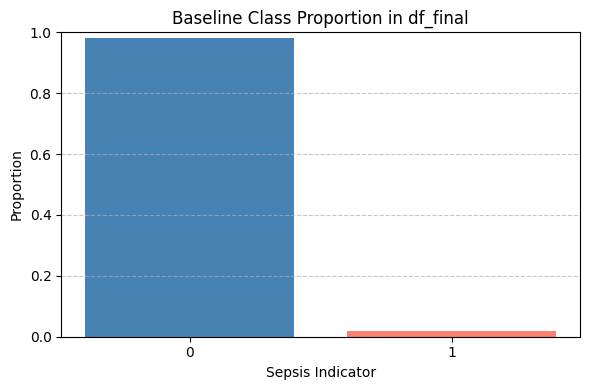

In [ ]:
#Current balance of the dataset for final_df = baseline proportion
print(df['SepsisIndicator'].value_counts(normalize=True))
data = {'SepsisIndicator': [0, 1], 'Proportion': [0.98, 0.02]}
df_plot = pd.DataFrame(data)

# Bar plot
plt.figure(figsize=(6, 4))
plt.bar(df_plot['SepsisIndicator'].astype(str), df_plot['Proportion'], color=['steelblue', 'salmon'])
plt.title('Baseline Class Proportion in df_final')
plt.xlabel('Sepsis Indicator')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 4. Handling Missing Data

A substantial portion of the dataset contains missing values, which is expected in clinical time-series data due to irregular testing intervals and varying clinical priorities. Handling these gaps is critical to ensure the robustness of the machine learning model.

Only clinically relevant features identified through a literature review and practical considerations were retained for modeling. Features with excessive missingness or limited predictive value were excluded. For instance, *Direct Bilirubin* was removed due to its collinearity with *Total Bilirubin* and availability for fewer than 2,000 patients.

### Final Features Selected:
- `HourOfObservation`, `PatientAge`, `ICULengthOfStay`,
- `PatientGender`, `TimeSinceHospitalAdmission`, `HeartRate`,
- `MeanArterialPressure`, `OxygenSaturation`, `SystolicBloodPressure`,
- `RespiratoryRate`, `DiastolicBloodPressure`, `Temperature`,
- `WhiteBloodCellCount`, `CreatinineLevel`
- `TotalBilirubin`, `PlateletCount`, `LactateLevel`

Multiple strategies were evaluated for managing missing data:
- Attempts to retain only complete cases (rows with no missing values) failed due to insufficient sample size.
- Forward-filling (`ffill`) was applied within each patient's time-series, emulating real-world clinical scenarios where recent test results are carried forward until new ones are available.
- After forward filling, only patients with adequately populated records were retained.

The resulting intermediate dataset includes **157,030 rows** and **20 columns**. To reflect the model's goal of producing hourly risk predictions and the nature of front end data integration, a `UniqueID` was generated for each row, and the original identifiers (`PatientID`, `CheckID`) were removed. Despite imputation, class imbalance remained an issue, with **95% non-sepsis** and **5% sepsis-positive** observations.



In [ ]:
#missing_values = df.isnull().sum()
#print("\nMissing Values per Column:")
#print(missing_values)

missing_percent = df.isnull().mean() * 100
missing_percent_sorted = missing_percent.sort_values()

print("\nPercentage of Missing Values per Column for all columns (Sorted):")
print(missing_percent_sorted)


Percentage of Missing Values per Column for all columns (Sorted):
CheckID                        0.000000
HourOfObservation              0.000000
PatientAge                     0.000000
PatientID                      0.000000
ICULengthOfStay                0.000000
SepsisIndicator                0.000000
PatientGender                  0.000000
TimeSinceHospitalAdmission     0.000515
HeartRate                      9.882619
MeanArterialPressure          12.451279
OxygenSaturation              13.061119
SystolicBloodPressure         14.576958
RespiratoryRate               15.354559
DiastolicBloodPressure        31.345887
CareUnit1                     39.425078
CareUnit2                     39.425078
Temperature                   66.162697
GlucoseLevel                  82.894325
PotassiumLevel                90.689082
Hematocrit                    91.145979
FractionInspiredOxygen        91.665754
Hemoglobin                    92.617558
pH                            93.069688
BloodUreaNitr

<Axes: >

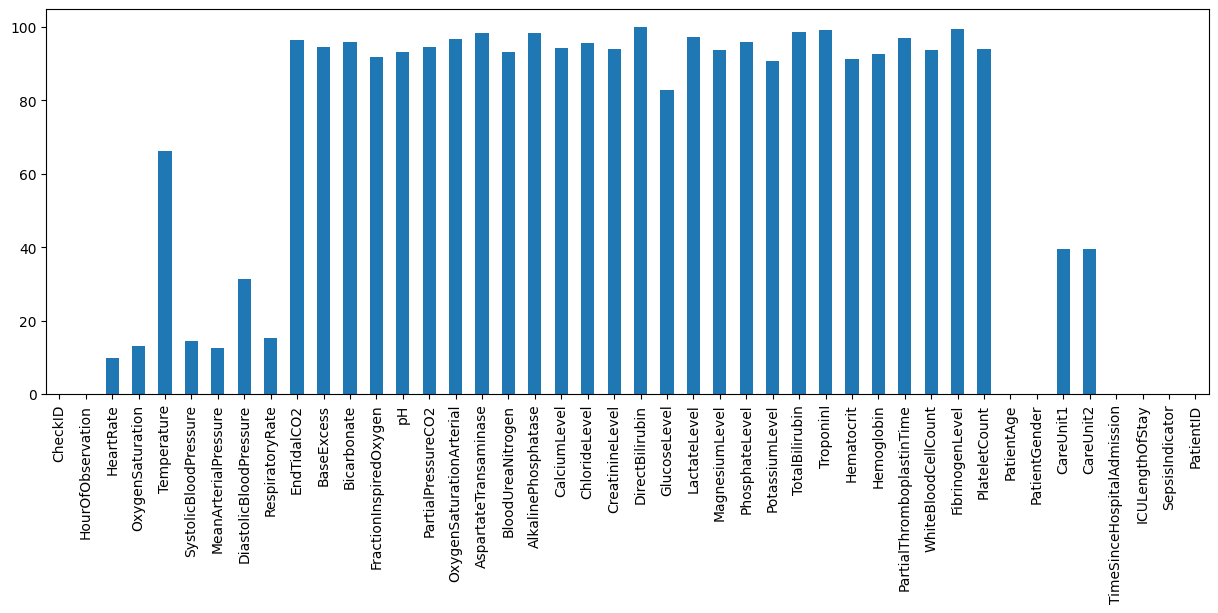

In [ ]:
#Visualisation of missing data
round(100*(df.isnull().sum()/len(df.index)),2).plot.bar(figsize=(15,5))

In [ ]:
patient_counts = df['PatientID'].nunique()
print("Number of unique patients overall:", patient_counts)

# Show the number of patients with all datapoints filled -no success
complete_cases_df1 = df.dropna()
complete_cases_df1.shape

Number of unique patients overall: 40336


(0, 44)

In [ ]:
#I will only select columns which have importance based on the literature review and some columns which has not much missing values
columns_to_keep = ['CheckID', 'HourOfObservation', 'PatientAge', 'PatientID', 'ICULengthOfStay',\
                   'SepsisIndicator', 'PatientGender', 'TimeSinceHospitalAdmission', 'HeartRate',\
                   'MeanArterialPressure', 'OxygenSaturation', 'SystolicBloodPressure', 'RespiratoryRate', \
                   'DiastolicBloodPressure', 'Temperature', 'WhiteBloodCellCount', \
                   'CreatinineLevel', 'TotalBilirubin', 'PlateletCount', 'LactateLevel']
df_filtered = df[columns_to_keep]
print(df_filtered.shape)
patient_num = df_filtered['PatientID'].nunique()
print("Number of unique patients in filtered data:", patient_num)

missing_data = df_filtered.isnull().mean() * 100
missing_data_sorted = missing_data.sort_values()

print("\nPercentage of Missing Values per Column (Sorted):")
print(missing_data_sorted)

(1552210, 20)
Number of unique patients in filtered data: 40336

Percentage of Missing Values per Column (Sorted):
CheckID                        0.000000
HourOfObservation              0.000000
PatientAge                     0.000000
PatientID                      0.000000
ICULengthOfStay                0.000000
SepsisIndicator                0.000000
PatientGender                  0.000000
TimeSinceHospitalAdmission     0.000515
HeartRate                      9.882619
MeanArterialPressure          12.451279
OxygenSaturation              13.061119
SystolicBloodPressure         14.576958
RespiratoryRate               15.354559
DiastolicBloodPressure        31.345887
Temperature                   66.162697
WhiteBloodCellCount           93.593199
CreatinineLevel               93.904433
PlateletCount                 94.059502
LactateLevel                  97.329872
TotalBilirubin                98.509158
dtype: float64


<Axes: >

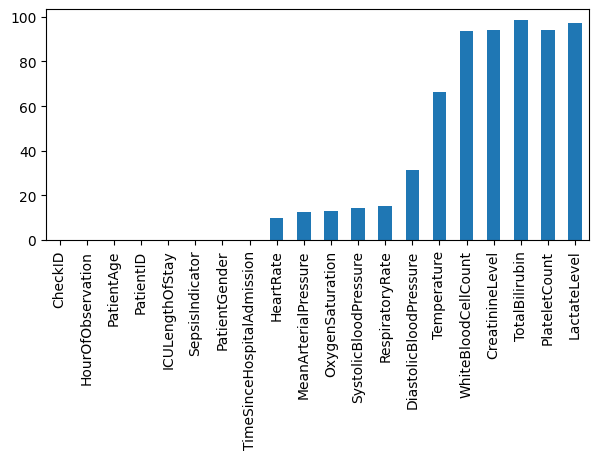

In [ ]:
#Visualisation of missing data
round(100*(df_filtered.isnull().sum()/len(df.index)),2).plot.bar(figsize=(7,3))

In [ ]:
df_filtered.head()

,CheckID,HourOfObservation,PatientAge,PatientID,ICULengthOfStay,SepsisIndicator,PatientGender,TimeSinceHospitalAdmission,HeartRate,MeanArterialPressure,OxygenSaturation,SystolicBloodPressure,RespiratoryRate,DiastolicBloodPressure,Temperature,WhiteBloodCellCount,CreatinineLevel,TotalBilirubin,PlateletCount,LactateLevel
0,0,0,68.54,17072,1,0,0,-0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,68.54,17072,2,0,0,-0.02,65.0,72.0,100.0,NaN,16.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,68.54,17072,3,0,0,-0.02,78.0,42.5,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,68.54,17072,4,0,0,-0.02,73.0,NaN,100.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,68.54,17072,5,0,0,-0.02,70.0,74.0,100.0,129.0,14.0,69.0,NaN,11.3,0.8,NaN,330.0,NaN


In [ ]:
columns_to_check = [
    'WhiteBloodCellCount',
    'CreatinineLevel',
    'PlateletCount',
    'LactateLevel',
    'TotalBilirubin',
    'DirectBilirubin'
]

# Keep only rows (patients) with no nulls in those columns
df_filtered_1 = df.dropna(subset=columns_to_check)
df_filtered_1.shape

#very few people, so this strategy do not work

(277, 44)

In [ ]:
#Just checked total number of patients by the column which has highest missing data and the intermediate one => to make sure enough data
print(df_filtered[df_filtered[['TotalBilirubin']].notna().any(axis=1)]['PatientID'].nunique())
df_filtered[df_filtered[['WhiteBloodCellCount']].notna().any(axis=1)]['PatientID'].nunique()

#The number of records is decent

14248


37711

In [ ]:
# All time-varying features to fill
cols_to_fill = [
    'HeartRate', 'MeanArterialPressure', 'OxygenSaturation', 'SystolicBloodPressure',
    'RespiratoryRate', 'DiastolicBloodPressure', 'Temperature',
    'WhiteBloodCellCount', 'CreatinineLevel', 'PlateletCount',
    'LactateLevel', 'TotalBilirubin'
]

# Function to apply forward fill per patient over time
def fill_time_varying_ffill_only(g):
    return g.sort_values('HourOfObservation').ffill()

# Apply forward fill within each patient
df_filled = df_filtered.groupby('PatientID', group_keys=False).apply(fill_time_varying_ffill_only)


<ipython-input-7-7156fb24bfcb>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df_filtered.groupby('PatientID', group_keys=False).apply(fill_time_varying_ffill_only)


In [ ]:
#df_filtered_filled.head(30)
missing_data = df_filled.isnull().mean() * 100
missing_data_sorted = missing_data.sort_values()

print("\nPercentage of Missing Values per Column (Sorted):")
print(missing_data_sorted)


Percentage of Missing Values per Column (Sorted):
CheckID                        0.000000
HourOfObservation              0.000000
PatientAge                     0.000000
PatientID                      0.000000
ICULengthOfStay                0.000000
SepsisIndicator                0.000000
PatientGender                  0.000000
TimeSinceHospitalAdmission     0.000515
HeartRate                      2.284291
OxygenSaturation               2.455660
MeanArterialPressure           2.777202
RespiratoryRate                3.069237
SystolicBloodPressure          3.881562
Temperature                    7.420323
DiastolicBloodPressure        20.654164
CreatinineLevel               21.396010
PlateletCount                 22.349102
WhiteBloodCellCount           22.534386
TotalBilirubin                69.790170
LactateLevel                  70.182321
dtype: float64


In [ ]:
df_filled.nunique()/len(df)*100 # percentage of unique values in each column
df_filled.nunique(axis=0)

,0
CheckID,336
HourOfObservation,336
PatientAge,5987
PatientID,40336
ICULengthOfStay,336
SepsisIndicator,2
PatientGender,2
TimeSinceHospitalAdmission,12156
HeartRate,343
MeanArterialPressure,945


In [ ]:
# Show the number of patients with all datapoints filled
complete_rows_df = df_filled.dropna()
print('Overall number fo rows left', complete_rows_df.shape)
#complete_rows_df.head()
print('Number of unique patients left:', complete_rows_df['PatientID'].nunique())

Overall number fo rows left (157030, 20)
Number of unique patients left: 4512


In [ ]:
#convert each row into a fake unique patient => make uniqueID collumn
complete_rows_df.loc[:, 'UniqueID'] = range(1, len(complete_rows_df) + 1)
complete_rows_df.head()

<ipython-input-11-52482523c41c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_rows_df.loc[:, 'UniqueID'] = range(1, len(complete_rows_df) + 1)


,CheckID,HourOfObservation,PatientAge,PatientID,ICULengthOfStay,SepsisIndicator,PatientGender,TimeSinceHospitalAdmission,HeartRate,MeanArterialPressure,...,SystolicBloodPressure,RespiratoryRate,DiastolicBloodPressure,Temperature,WhiteBloodCellCount,CreatinineLevel,TotalBilirubin,PlateletCount,LactateLevel,UniqueID
37,37,37,68.54,17072,38,0,0,-0.02,67.0,66.0,...,115.0,14.0,109.0,36.67,16.4,0.7,0.7,317.0,1.9,1
38,38,38,68.54,17072,39,0,0,-0.02,64.0,66.0,...,115.0,14.0,109.0,36.67,16.4,0.7,0.7,317.0,1.9,2
39,39,39,68.54,17072,40,0,0,-0.02,72.0,71.0,...,115.0,14.0,109.0,37.44,16.4,0.7,0.7,317.0,1.9,3
40,40,40,68.54,17072,41,0,0,-0.02,71.0,71.0,...,115.0,14.0,109.0,37.44,16.4,0.7,0.7,317.0,1.9,4
41,41,41,68.54,17072,42,0,0,-0.02,70.0,70.0,...,115.0,14.0,109.0,37.44,16.4,0.7,0.7,317.0,1.9,5


In [ ]:
percent_unique = complete_rows_df.nunique() / len(complete_rows_df) * 100 # percentage of unique values in each column
print(percent_unique.round(2))

CheckID                         0.21
HourOfObservation               0.21
PatientAge                      1.25
PatientID                       2.87
ICULengthOfStay                 0.21
SepsisIndicator                 0.00
PatientGender                   0.00
TimeSinceHospitalAdmission      1.64
HeartRate                       0.19
MeanArterialPressure            0.40
OxygenSaturation                0.08
SystolicBloodPressure           0.41
RespiratoryRate                 0.11
DiastolicBloodPressure          0.24
Temperature                     0.28
WhiteBloodCellCount             0.33
CreatinineLevel                 0.49
TotalBilirubin                  0.20
PlateletCount                   0.43
LactateLevel                    0.72
UniqueID                      100.00
dtype: float64


In [ ]:
#Drop patientID collumn as no longer needed (look cell above for reasoning)
df_final = complete_rows_df.drop(['PatientID', 'CheckID'], axis=1)
df_final.shape
df_final.head()

,HourOfObservation,PatientAge,ICULengthOfStay,SepsisIndicator,PatientGender,TimeSinceHospitalAdmission,HeartRate,MeanArterialPressure,OxygenSaturation,SystolicBloodPressure,RespiratoryRate,DiastolicBloodPressure,Temperature,WhiteBloodCellCount,CreatinineLevel,TotalBilirubin,PlateletCount,LactateLevel,UniqueID
37,37,68.54,38,0,0,-0.02,67.0,66.0,100.0,115.0,14.0,109.0,36.67,16.4,0.7,0.7,317.0,1.9,1
38,38,68.54,39,0,0,-0.02,64.0,66.0,100.0,115.0,14.0,109.0,36.67,16.4,0.7,0.7,317.0,1.9,2
39,39,68.54,40,0,0,-0.02,72.0,71.0,100.0,115.0,14.0,109.0,37.44,16.4,0.7,0.7,317.0,1.9,3
40,40,68.54,41,0,0,-0.02,71.0,71.0,100.0,115.0,14.0,109.0,37.44,16.4,0.7,0.7,317.0,1.9,4
41,41,68.54,42,0,0,-0.02,70.0,70.0,99.0,115.0,14.0,109.0,37.44,16.4,0.7,0.7,317.0,1.9,5


In [ ]:
# basic data structure structure
print("Shape:", df_final.shape)
print("\nData Types:\n", df_final.dtypes)
#One categorical variable: PatientGender (already encoded)
# The rest is numerical values

Shape: (157030, 19)

Data Types:
 HourOfObservation               int64
PatientAge                    float64
ICULengthOfStay                 int64
SepsisIndicator                 int64
PatientGender                   int64
TimeSinceHospitalAdmission    float64
HeartRate                     float64
MeanArterialPressure          float64
OxygenSaturation              float64
SystolicBloodPressure         float64
RespiratoryRate               float64
DiastolicBloodPressure        float64
Temperature                   float64
WhiteBloodCellCount           float64
CreatinineLevel               float64
TotalBilirubin                float64
PlateletCount                 float64
LactateLevel                  float64
UniqueID                        int64
dtype: object


In [ ]:
#Check whether any missing values left
missing_data = df_final.isnull().mean() * 100
missing_data_sorted = missing_data.sort_values()

print("\nPercentage of Missing Values per Column (Sorted):")
print(missing_data_sorted)


Percentage of Missing Values per Column (Sorted):
HourOfObservation             0.0
PatientAge                    0.0
ICULengthOfStay               0.0
SepsisIndicator               0.0
PatientGender                 0.0
TimeSinceHospitalAdmission    0.0
HeartRate                     0.0
MeanArterialPressure          0.0
OxygenSaturation              0.0
SystolicBloodPressure         0.0
RespiratoryRate               0.0
DiastolicBloodPressure        0.0
Temperature                   0.0
WhiteBloodCellCount           0.0
CreatinineLevel               0.0
TotalBilirubin                0.0
PlateletCount                 0.0
LactateLevel                  0.0
UniqueID                      0.0
dtype: float64


SepsisIndicator
0    0.949105
1    0.050895
Name: proportion, dtype: float64


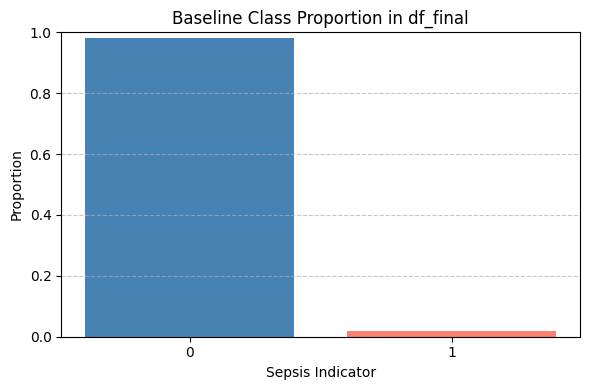

In [ ]:
#Current balance of the dataset for final_df = baseline proportion
print(df_final['SepsisIndicator'].value_counts(normalize=True))
data = {'SepsisIndicator': [0, 1], 'Proportion': [0.98, 0.02]}
df_plot = pd.DataFrame(data)

# Bar plot
plt.figure(figsize=(6, 4))
plt.bar(df_plot['SepsisIndicator'].astype(str), df_plot['Proportion'], color=['steelblue', 'salmon'])
plt.title('Baseline Class Proportion in df_final')
plt.xlabel('Sepsis Indicator')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
dups = df_final.duplicated()
dups.any()

np.False_

## 5. Exploratory Data Analysis (EDA)

A more detailed inspection of the data was conducted to understand distributional properties, feature relationships, and potential separability between sepsis and non-sepsis cases.

### Distribution Analysis
- Most numerical variables exhibit **skewed distributions**, consistent with clinical data collected across a heterogeneous patient population.
- **Boxplots** revealed the presence of **outliers**, which may reflect extreme physiological states or rare events—important for sepsis prediction.

### Correlation and Feature Relationships
- **Pearson correlation** showed weak or no linear associations between features and the target variable (`SepsisIndicator`).
- **Spearman correlation**, which captures monotonic relationships, confirmed that only a few variables had weak correlations with the outcome.
- To capture non-linear dependencies, **Mutual Information** was calculated, providing more robust insights into which features might contribute useful signal for classification.


### Conclusion
Given the absence of strong linear patterns and the complex feature space, **XGBoost** was selected as the primary model due to:
- Its ability to **model non-linear feature interactions** and **handle high-dimensional data** effectively.
- **No requirement for feature normalization**, simplifying the preprocessing pipeline.
- Proven performance in clinical prediction tasks and robustness to outliers and imbalanced datasets.
- Interpretability



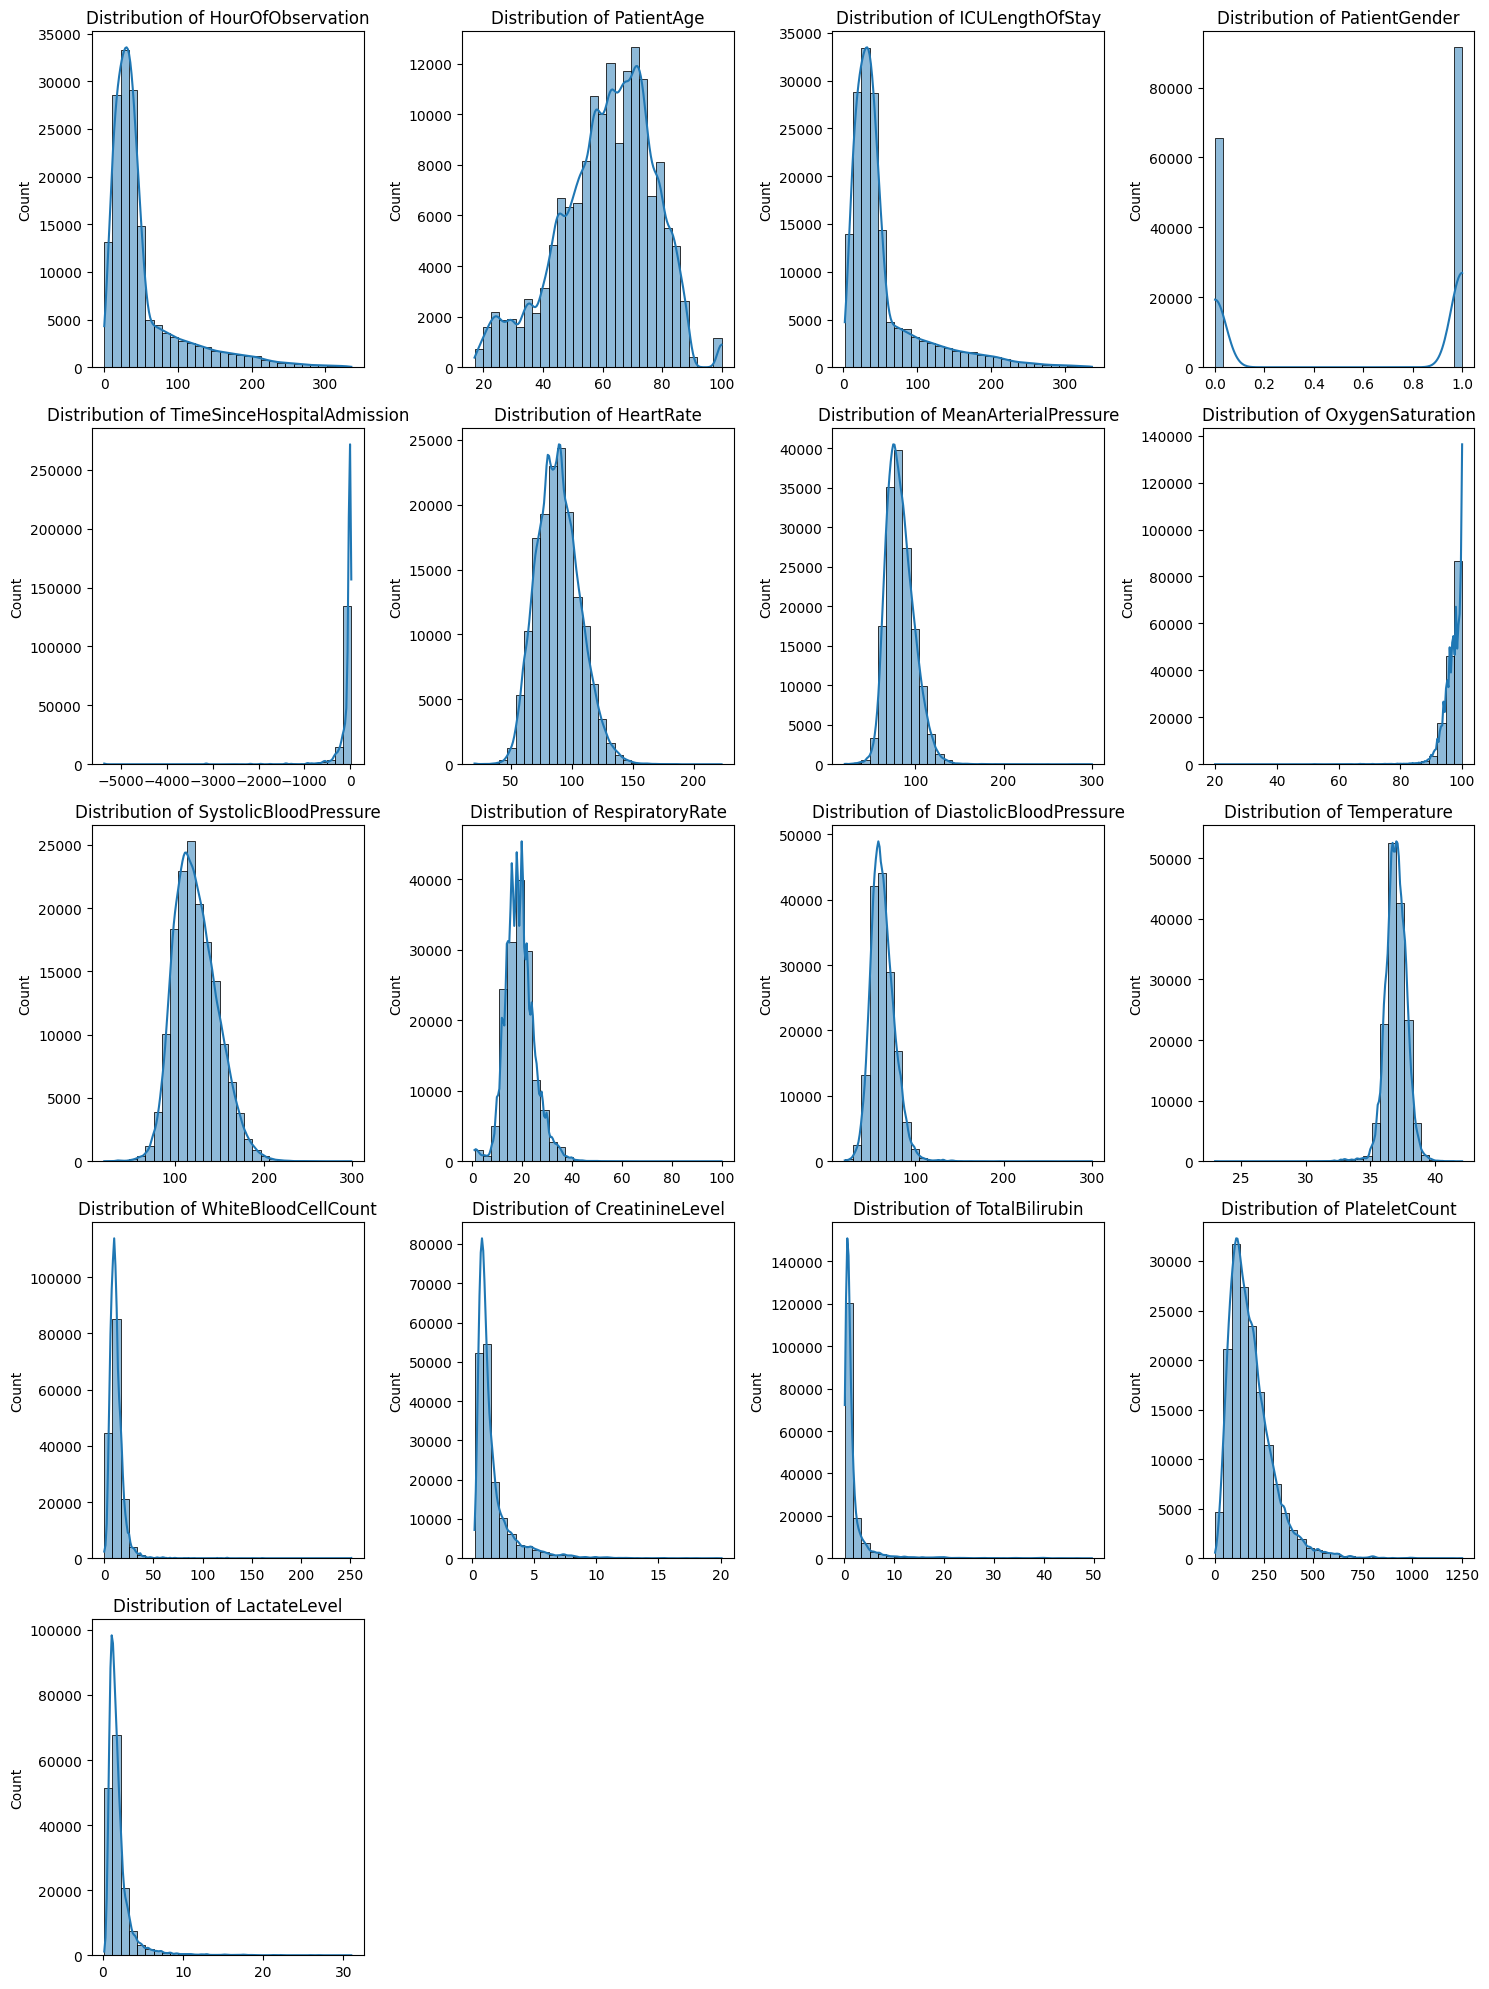

In [ ]:
# visualize distribution of numerical features
num_cols = [
    "HourOfObservation",	"PatientAge",
    "ICULengthOfStay",	"PatientGender",
    "TimeSinceHospitalAdmission",	"HeartRate",	"MeanArterialPressure",
    "OxygenSaturation",	"SystolicBloodPressure", "RespiratoryRate",	"DiastolicBloodPressure",
    "Temperature",	"WhiteBloodCellCount",	"CreatinineLevel",	"TotalBilirubin",
    "PlateletCount",	"LactateLevel"
]

plt.figure(figsize=(15, 20))
for i, col in enumerate(num_cols):
    plt.subplot(5, 4, i + 1)
    sns.histplot(df_final[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel('')
plt.tight_layout()
plt.show()

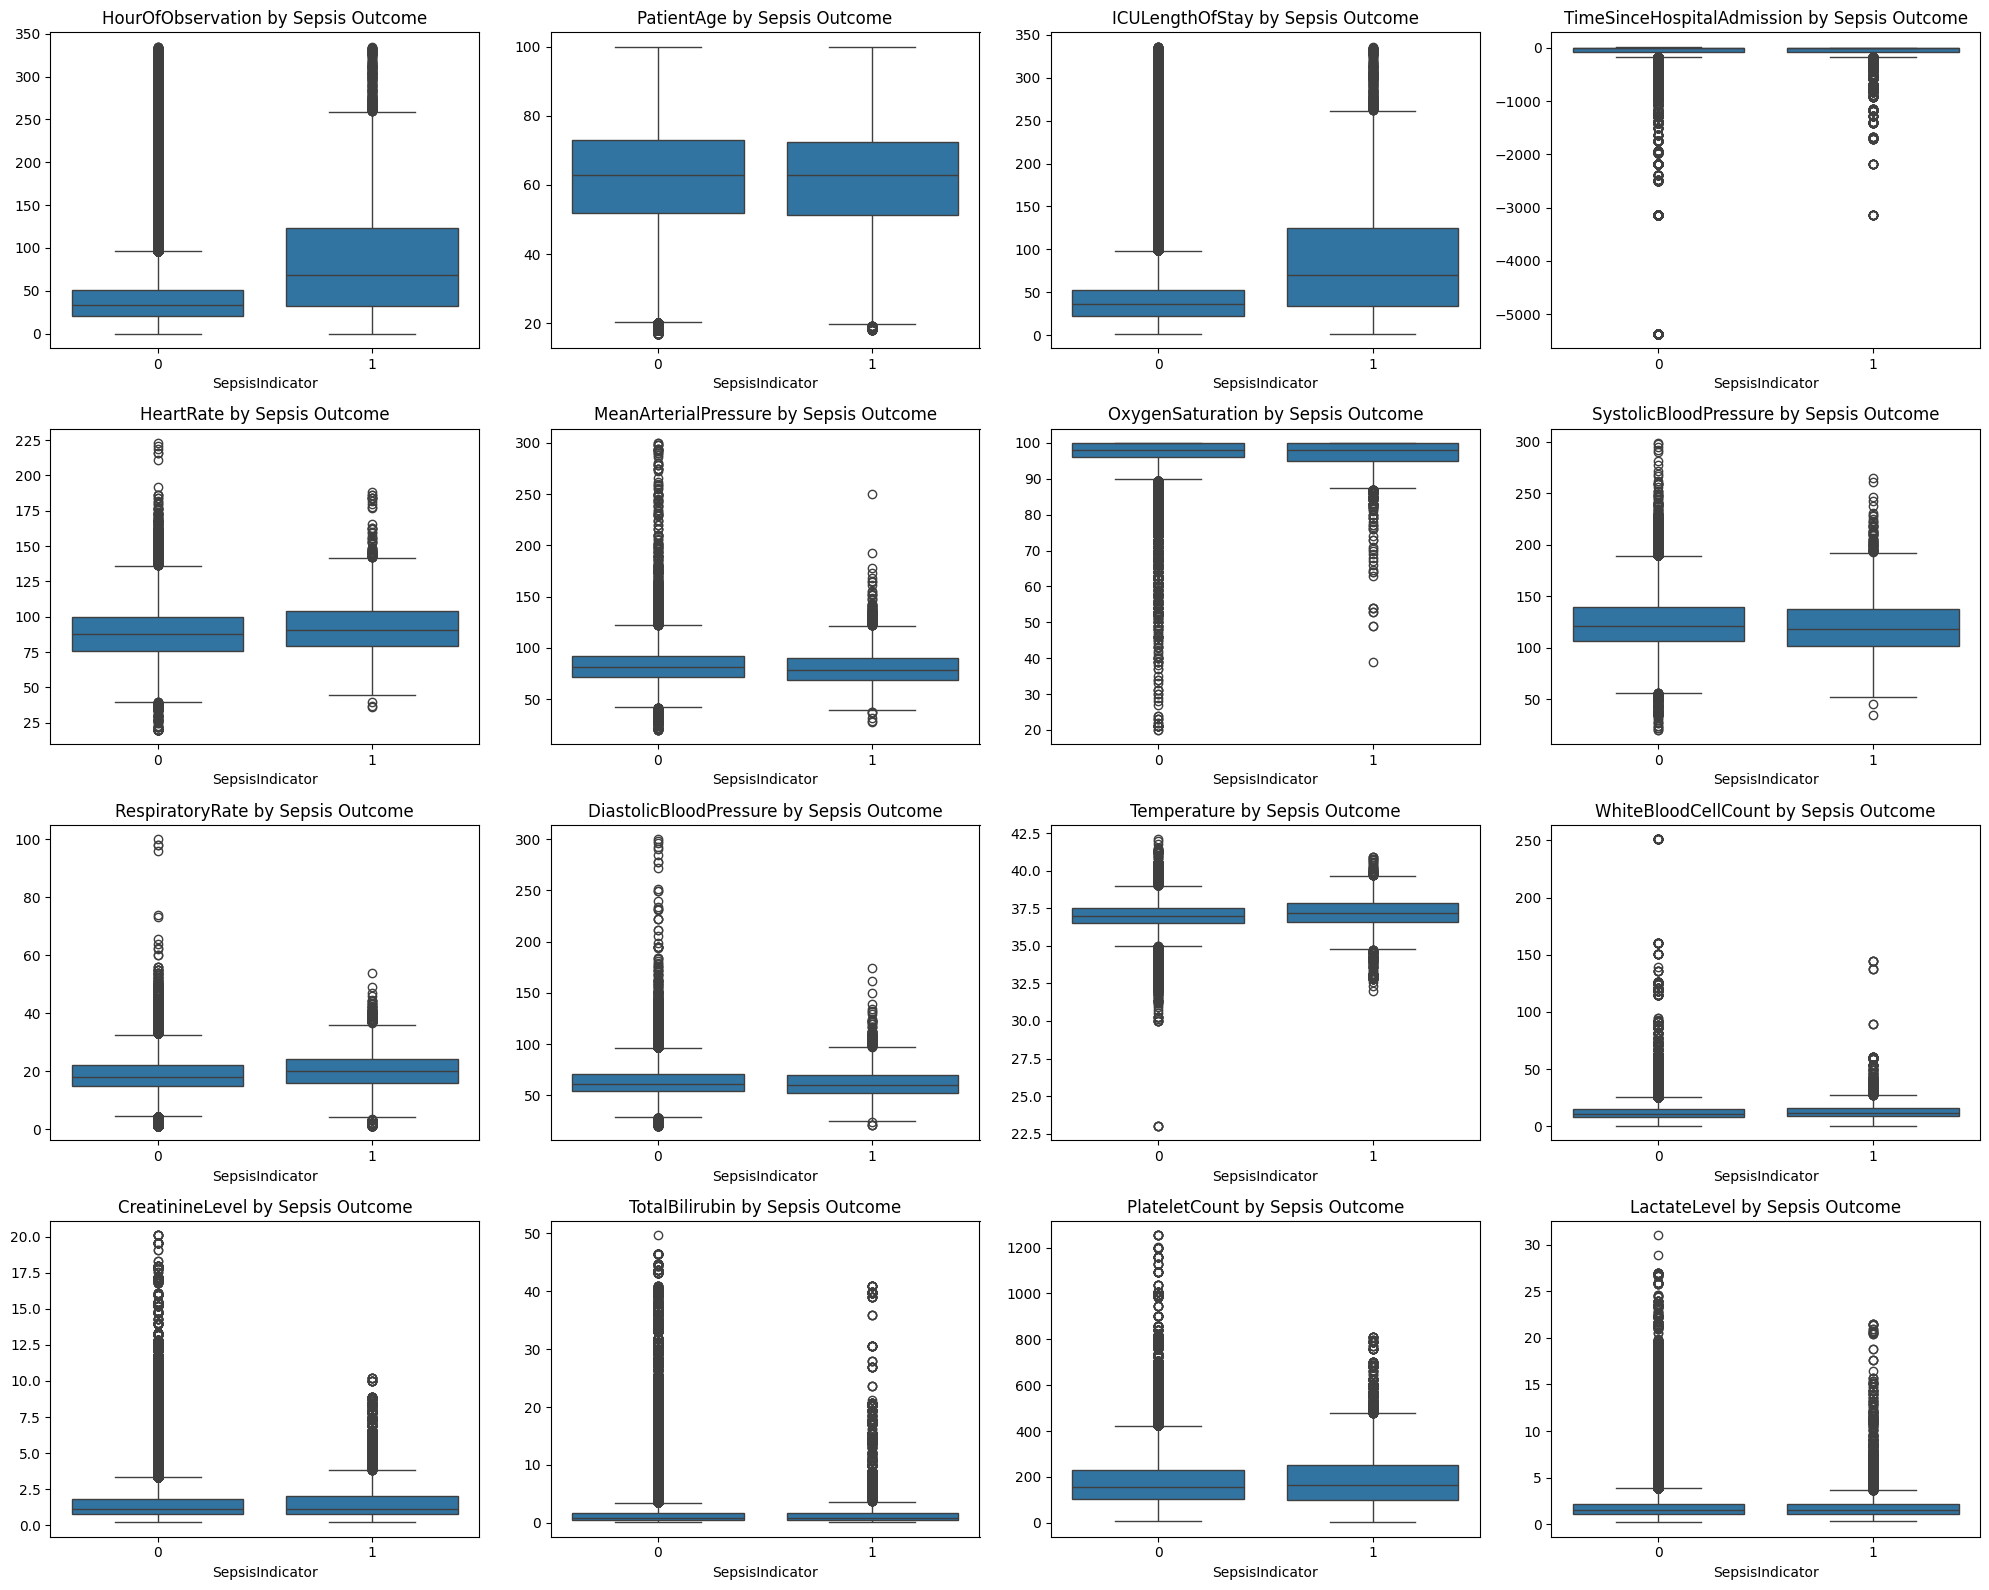

In [ ]:
num_cols = [
    "HourOfObservation", "PatientAge", "ICULengthOfStay", "TimeSinceHospitalAdmission",
    "HeartRate", "MeanArterialPressure", "OxygenSaturation", "SystolicBloodPressure",
    "RespiratoryRate", "DiastolicBloodPressure", "Temperature", "WhiteBloodCellCount",
    "CreatinineLevel", "TotalBilirubin", "PlateletCount", "LactateLevel"
]
# Ensure you don't exceed subplot limit per row (e.g., 4x4)
plt.figure(figsize=(20, 16))
for i, col in enumerate(num_cols):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(x='SepsisIndicator', y=col, data=df_final)
    plt.title(f"{col} by Sepsis Outcome")
    plt.xlabel('SepsisIndicator')
    plt.ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
#check the statistics of all columns
df_final.describe(include="all") #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! make something with outliers

,HourOfObservation,PatientAge,ICULengthOfStay,SepsisIndicator,PatientGender,TimeSinceHospitalAdmission,HeartRate,MeanArterialPressure,OxygenSaturation,SystolicBloodPressure,RespiratoryRate,DiastolicBloodPressure,Temperature,WhiteBloodCellCount,CreatinineLevel,TotalBilirubin,PlateletCount,LactateLevel,UniqueID
count,157030.000000,157030.000000,157030.00000,157030.000000,157030.000000,157030.000000,157030.000000,157030.000000,157030.000000,157030.000000,157030.000000,157030.000000,157030.000000,157030.000000,157030.000000,157030.000000,157030.000000,157030.000000,157030.000000
mean,52.372298,61.399305,54.00817,0.050895,0.582678,-87.198197,88.732066,82.648001,97.108919,123.506131,19.084407,62.957412,36.981769,12.380443,1.645265,1.916707,181.590909,2.043218,78515.500000
std,52.687692,15.737144,52.72274,0.219783,0.493118,301.336319,17.853516,16.202312,3.702233,24.748802,5.869692,13.862010,0.817922,8.155095,1.628506,3.747977,110.689752,1.900364,45330.800723
min,0.000000,17.000000,2.00000,0.000000,0.000000,-5366.860000,20.000000,20.000000,20.000000,20.000000,1.000000,20.000000,23.000000,0.100000,0.200000,0.100000,2.000000,0.200000,1.000000
25%,22.000000,51.890000,23.00000,0.000000,0.000000,-68.870000,76.000000,71.000000,96.000000,106.000000,15.000000,54.000000,36.500000,8.000000,0.770000,0.500000,104.000000,1.100000,39258.250000
50%,35.000000,63.000000,36.00000,0.000000,1.000000,-9.200000,88.000000,81.000000,98.000000,121.000000,18.500000,61.000000,37.000000,11.000000,1.100000,0.900000,159.000000,1.550000,78515.500000
75%,54.000000,73.000000,56.00000,0.000000,1.000000,-0.030000,100.000000,92.000000,100.000000,139.000000,22.000000,71.000000,37.500000,15.000000,1.800000,1.700000,233.000000,2.200000,117772.750000
max,335.000000,100.000000,336.00000,1.000000,1.000000,23.990000,223.000000,300.000000,100.000000,299.000000,100.000000,300.000000,42.100000,251.000000,20.080000,49.600000,1253.000000,31.000000,157030.000000


Correlations

In [ ]:
y = 'SepsisIndicator'
correlation_with_y = df_final.corr()[y].sort_values(ascending=False)
print("Correlation between SepsisLabel and each feature:")
print(correlation_with_y)

Correlation between SepsisLabel and each feature:
SepsisIndicator               1.000000
ICULengthOfStay               0.150430
HourOfObservation             0.148897
Temperature                   0.057668
RespiratoryRate               0.045759
HeartRate                     0.041057
WhiteBloodCellCount           0.031525
PlateletCount                 0.021937
CreatinineLevel               0.011737
TotalBilirubin                0.010759
TimeSinceHospitalAdmission    0.005360
LactateLevel                  0.000649
PatientAge                   -0.000494
PatientGender                -0.001632
OxygenSaturation             -0.011696
UniqueID                     -0.014281
DiastolicBloodPressure       -0.020025
SystolicBloodPressure        -0.020243
MeanArterialPressure         -0.029011
Name: SepsisIndicator, dtype: float64


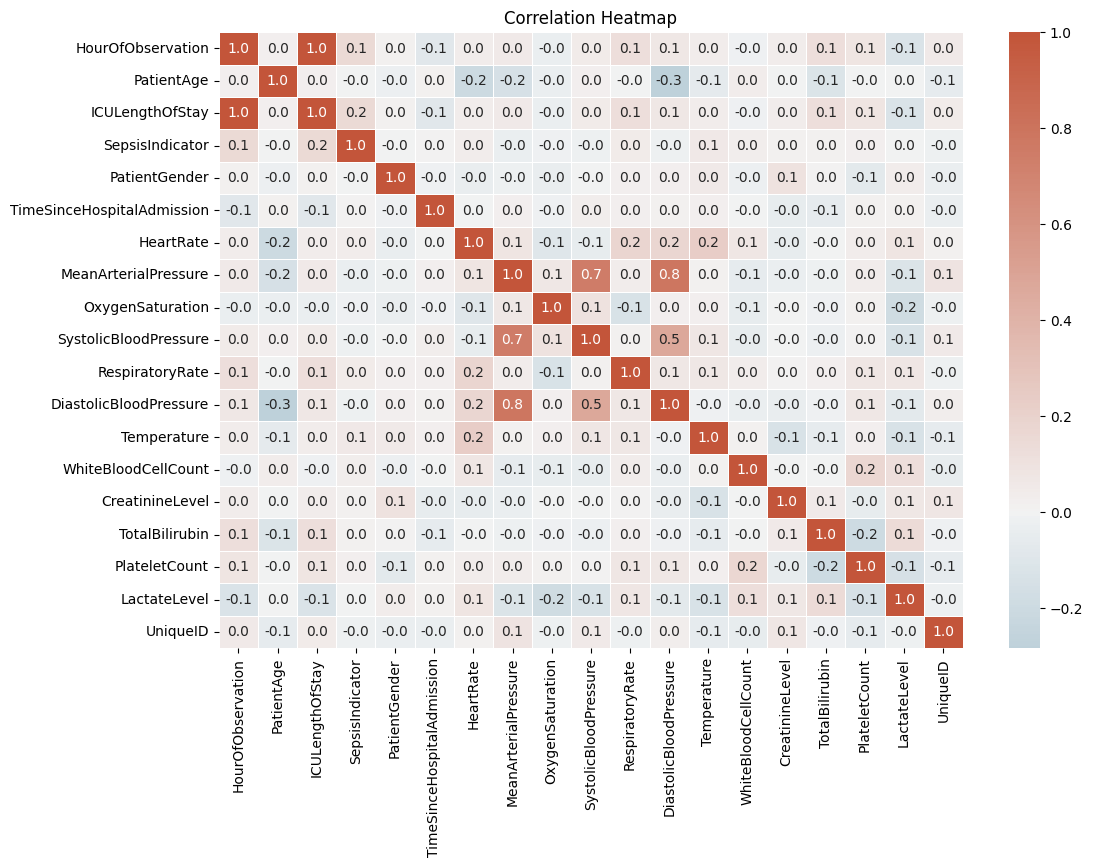

In [ ]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(12, 8))
sns.heatmap(df_final.corr(), annot=True, cmap=cmap, fmt=".1f", center=0, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
#Mutual Information Instead of Correlation
## Mutual Information captures any relationship, not just linear.
from sklearn.feature_selection import mutual_info_classif

X = df_final[["HourOfObservation",	"PatientAge",
    "ICULengthOfStay",	"SepsisIndicator",	"PatientGender",
    "TimeSinceHospitalAdmission",	"HeartRate",	"MeanArterialPressure",
    "OxygenSaturation",	"SystolicBloodPressure", "RespiratoryRate",	"DiastolicBloodPressure",
    "Temperature",	"WhiteBloodCellCount",	"CreatinineLevel",	"TotalBilirubin",
    "PlateletCount",	"LactateLevel"]]
y = df_final['SepsisIndicator']
mi = mutual_info_classif(X, y)
print(mi)

[0.01405872 0.03867416 0.0142419  0.20156484 0.02712905 0.04918837
 0.00094574 0.00098412 0.00449086 0.00112738 0.00336999 0.00112689
 0.00659007 0.01039858 0.01188739 0.004753   0.01329063 0.01086584]


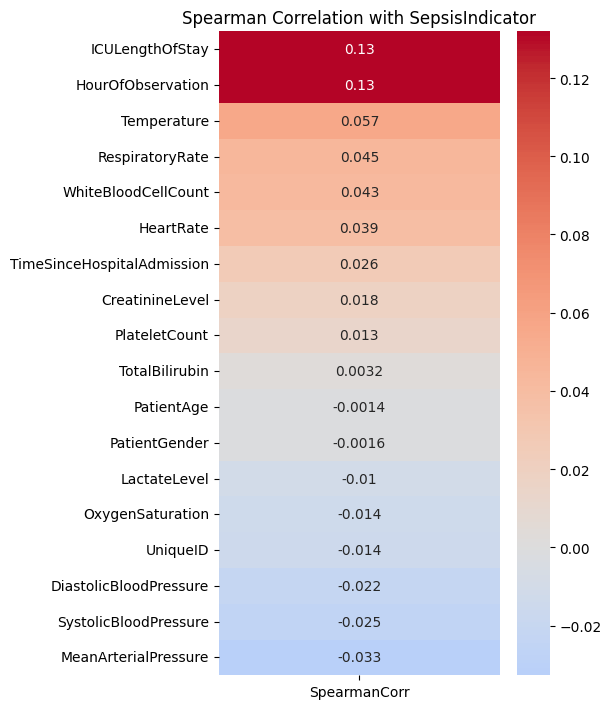

In [ ]:
#Spearman Correlation

# Select only numeric columns (excluding SepsisIndicator temporarily)
numeric_cols = df_final.select_dtypes(include='number').columns.drop('SepsisIndicator')

# Calculate Spearman correlation between each feature and SepsisIndicator
correlations = df_final[numeric_cols].corrwith(df_final['SepsisIndicator'], method='spearman')

# Convert to DataFrame for heatmap
corr_df = correlations.to_frame(name='SpearmanCorr').sort_values(by='SpearmanCorr', ascending=False)

# Plot as a heatmap
plt.figure(figsize=(6, len(corr_df) * 0.4))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0, cbar=True)
plt.title('Spearman Correlation with SepsisIndicator')
plt.tight_layout()
plt.show()

### Data Balancing Methodology

To address the severe class imbalance in the dataset (rare sepsis cases), we applied **random undersampling**.

### Method
- Randomly selected a subset of non-sepsis (`SepsisIndicator = 0`) cases to match the number of sepsis (`SepsisIndicator = 1`) cases.
- Created a balanced dataset (`df_balanced`) with **50% sepsis** and **50% non-sepsis**.
- Balancing was performed across the **entire dataset** before model training.

### Purpose
- **Prevent model bias** toward predicting the majority class (non-sepsis).
- **Improve sensitivity (recall)** for detecting sepsis cases.
- **Ensure fairer evaluation** of model performance.

### Robustness
- **Strengths:** Simple, quick, and effective for early modeling.
- **Limitations:** Discards a large portion of majority class data, risking loss of information and increased variance.
- **Alternative considered:**  
  - **SMOTE** (Synthetic Minority Oversampling Technique) was tested but did **not improve** performance.

Thus, random undersampling was chosen as a practical and sufficient approach for this project stage.

In [ ]:
#Balancing due to high imbalance between sepsis 1 and 0 groups
# Split the dataset by class
sepsis = df_final[df_final['SepsisIndicator'] == 1]
non_sepsis = df_final[df_final['SepsisIndicator'] == 0]

# Downsample non-sepsis to match sepsis count
non_sepsis_downsampled = non_sepsis.sample(n=sepsis.shape[0], random_state=42)

# Combine both to create a balanced dataset
df_balanced = pd.concat([sepsis, non_sepsis_downsampled]).sample(frac=1, random_state=42)  # Shuffle

# Check class balance
print(df_balanced['SepsisIndicator'].value_counts(normalize=True))
df_balanced.shape


SepsisIndicator
0    0.5
1    0.5
Name: proportion, dtype: float64


(15984, 19)

####Additional EDA on balanced dataset

### Bivariate Analysis
Bivariate boxplots comparing each feature by sepsis status showed marginal shifts in distributions for some clinical variables (e.g., *HeartRate*, *LactateLevel*, *Temperature*), suggesting their potential utility in distinguishing sepsis cases. However, the overlap across groups reinforces the need for a multivariate, non-linear approach.

### Dimensionality Reduction and Clustering
Principal Component Analysis (PCA) and unsupervised clustering methods were explored to evaluate whether patients with and without sepsis naturally group in the feature space. The results showed **no clear separability**, further justifying the use of a complex classifier that can model non-linear interactions.

Bivariate Analysis

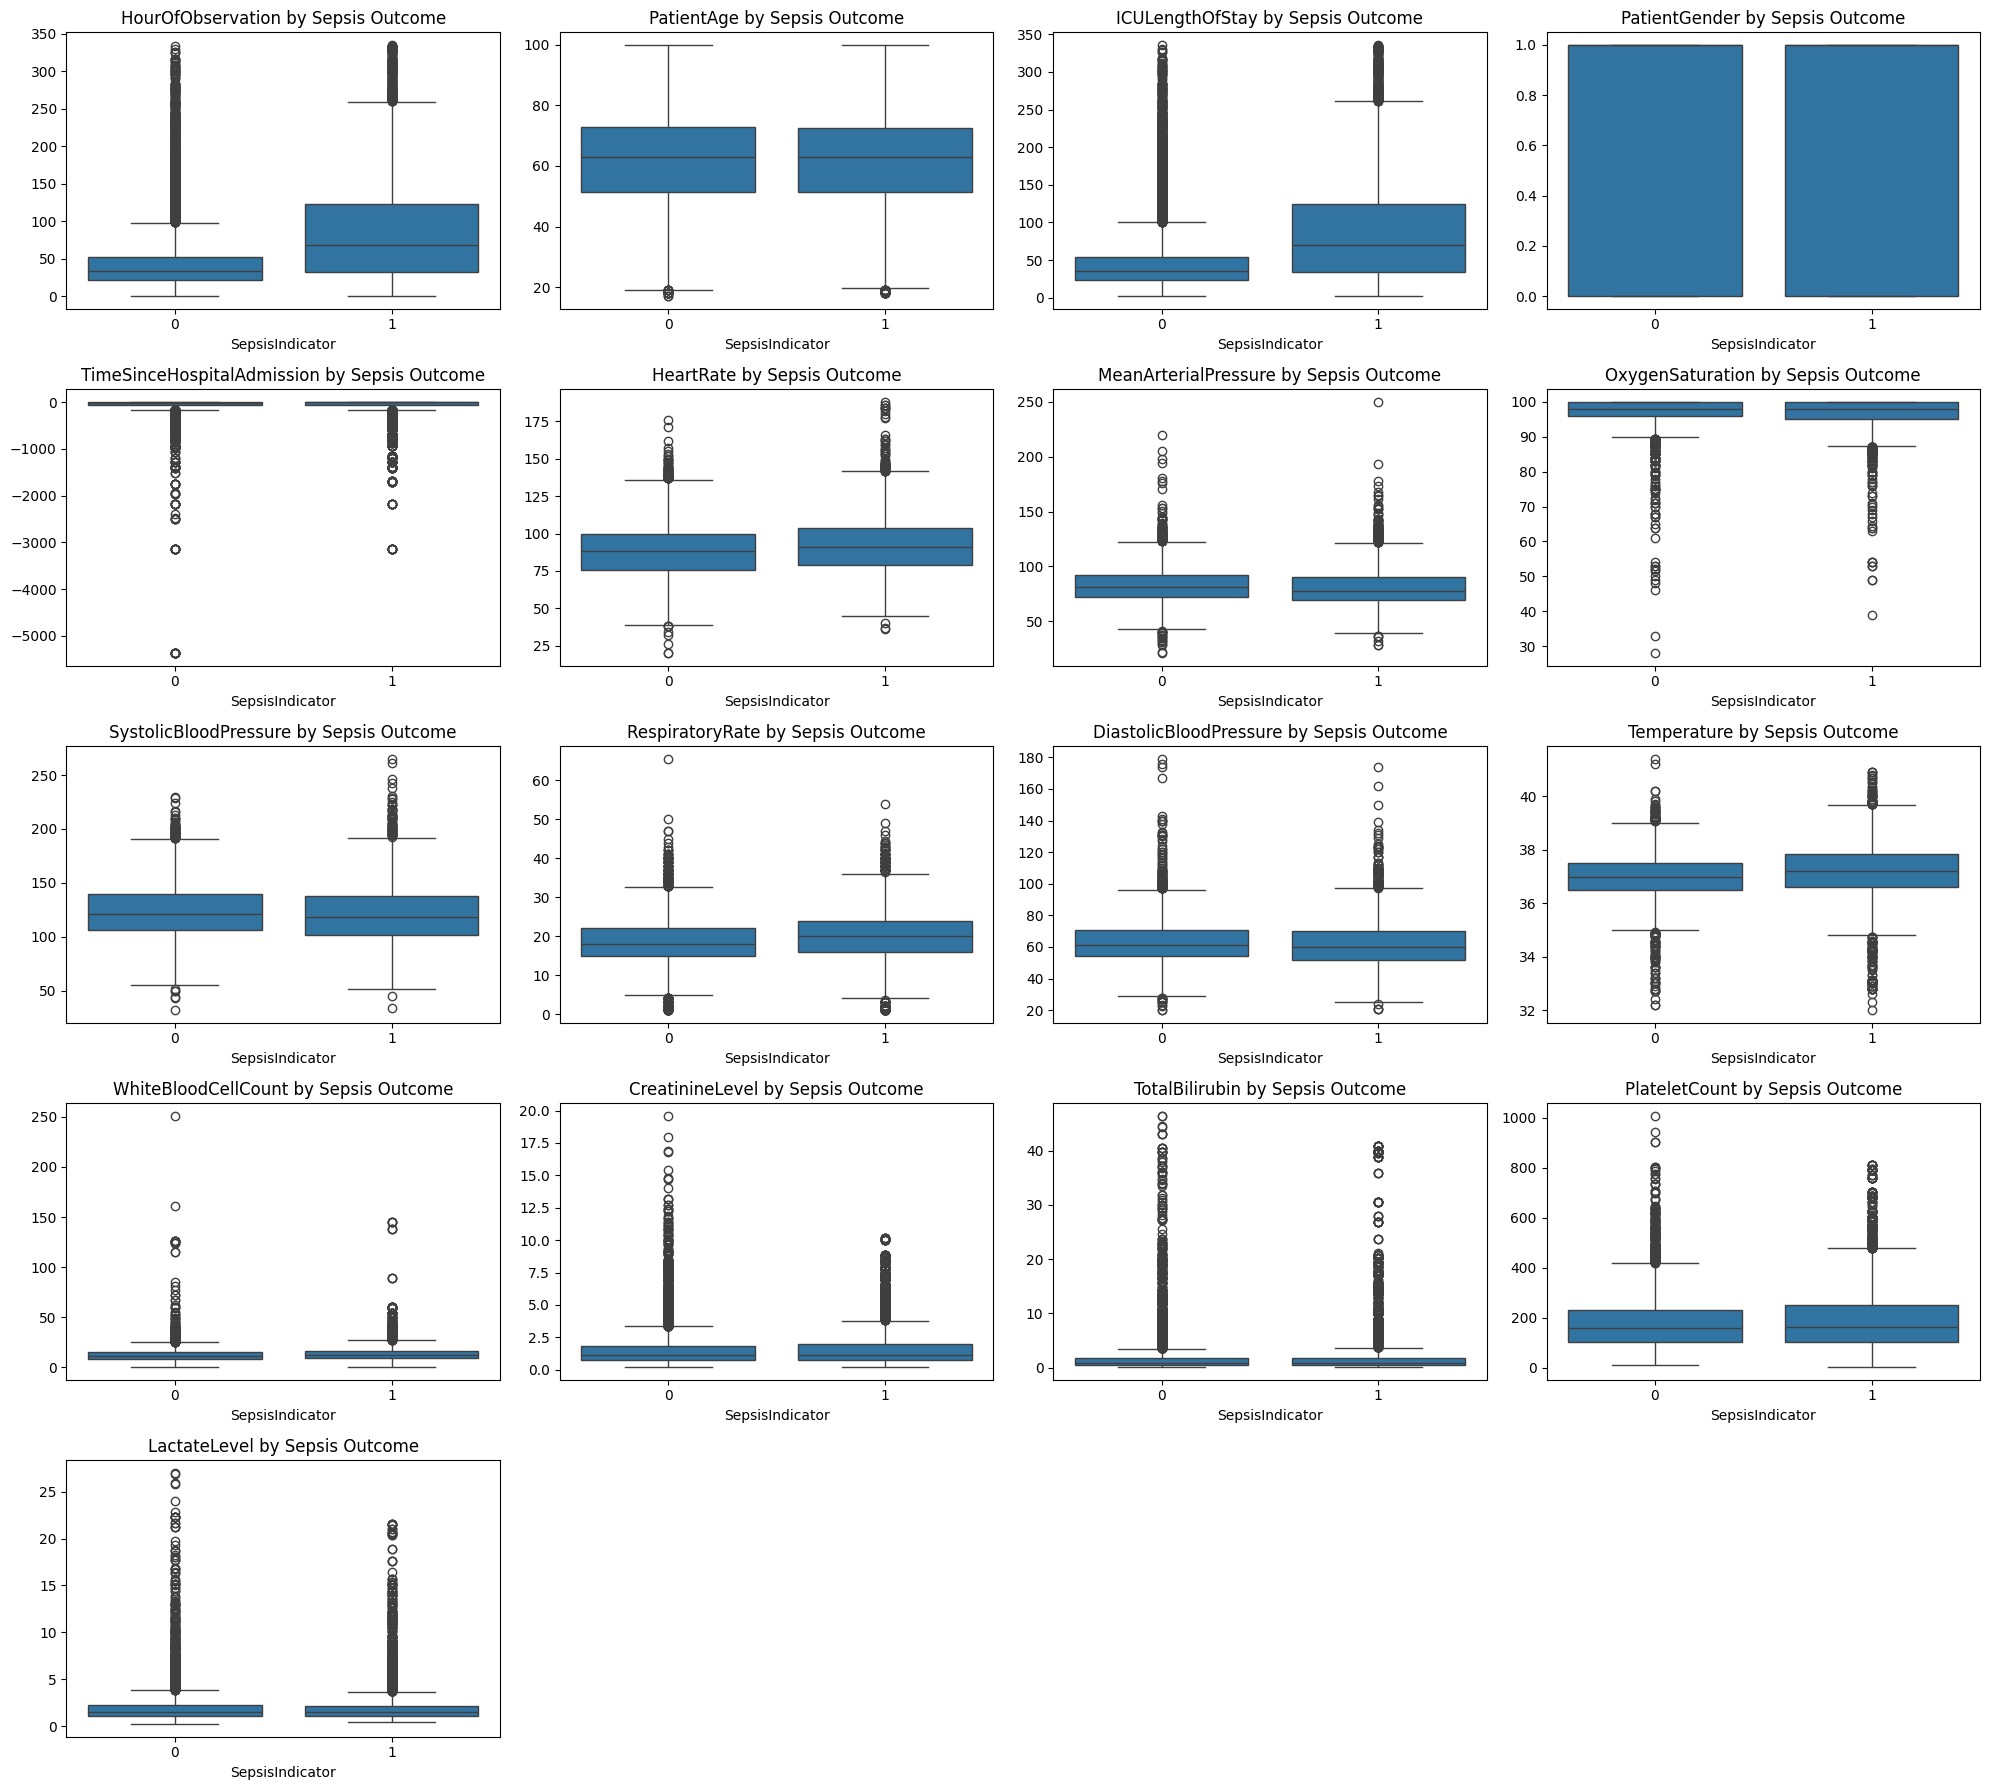

In [ ]:
# Selected top features from SHAP (excluding TimeSinceHospitalAdmission, Gender)
important_features = [
    'ICULengthOfStay', 'Temperature', 'WhiteBloodCellCount', 'PatientAge',
    'LactateLevel', 'CreatinineLevel', 'PlateletCount', 'TotalBilirubin',
    'DiastolicBloodPressure', 'HeartRate', 'HourOfObservation',
    'SystolicBloodPressure', 'MeanArterialPressure', 'RespiratoryRate',
    'OxygenSaturation'
]

plt.figure(figsize=(20, 18))
for i, col in enumerate(num_cols):
    plt.subplot(5, 4, i + 1)  # 5 rows, 4 columns = 20 slots
    sns.boxplot(x='SepsisIndicator', y=col, data=df_balanced)
    plt.title(f"{col} by Sepsis Outcome")
    plt.xlabel('SepsisIndicator')
    plt.ylabel('')
plt.tight_layout()
plt.show()


PCA/Cluster Analysis Snippet

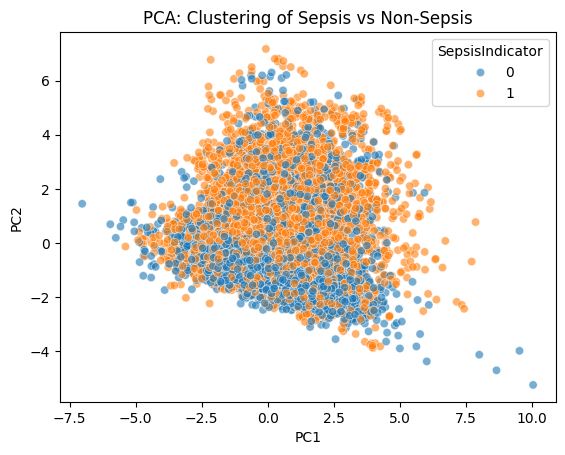

In [ ]:
# Select numerical features
numerical_cols = df_balanced.select_dtypes(include='number').drop(columns=['SepsisIndicator']).columns
X_scaled = StandardScaler().fit_transform(df_balanced[numerical_cols].fillna(0))  # Replace missing if needed

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Plot
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['SepsisIndicator'] = df_balanced['SepsisIndicator'].values

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='SepsisIndicator', alpha=0.6)
plt.title('PCA: Clustering of Sepsis vs Non-Sepsis')
plt.show()


In [ ]:
#Download df_balanced to csv
df_balanced.to_csv('df_balanced.csv', index=False)

from google.colab import files
files.download('df_balanced.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data Pipeline and Model Application

Built a preprocessing pipeline:
- **Numerical features**: Median imputation ➔ Standard scaling
- **Categorical feature** (PatientGender): Most frequent imputation ➔ One-hot encoding
- Combined preprocessing and an XGBoost classifier into a full sklearn `Pipeline`.
---

### Model Performance

**Classification Report Results:**
- Final **Recall**: 0.92 (important metric for this case)
- Final **F1-score**: 0.88
- Good balance between precision, recall, and F1-score for both sepsis and non-sepsis groups.
- Model achieved strong predictive performance, identifying patients at risk effectively.

---

### Conclusion
- The XGBoost-based pipeline accurately predicts sepsis risk using routine clinical variables.  
- It handles missing data and feature scaling automatically, making it suitable for real-time deployment.


In [ ]:
import os

# Define the file path
file_path = "df_balanced.csv"

# Check if the file exists before reading
if os.path.exists(file_path):
    # Read CSV file into a DataFrame
    df_balanced = pd.read_csv(file_path)
    print("File successfully loaded.")
else:
    print(f"File not found: {file_path}")


File successfully loaded.


In [ ]:
print(df_balanced.columns.tolist())

['HourOfObservation', 'PatientAge', 'ICULengthOfStay', 'SepsisIndicator', 'PatientGender', 'TimeSinceHospitalAdmission', 'HeartRate', 'MeanArterialPressure', 'OxygenSaturation', 'SystolicBloodPressure', 'RespiratoryRate', 'DiastolicBloodPressure', 'Temperature', 'WhiteBloodCellCount', 'CreatinineLevel', 'TotalBilirubin', 'PlateletCount', 'LactateLevel', 'UniqueID']


In [ ]:
features = [
    "HourOfObservation", "PatientAge", "ICULengthOfStay", "PatientGender",
    "TimeSinceHospitalAdmission", "HeartRate", "MeanArterialPressure",
    "OxygenSaturation", "SystolicBloodPressure", "RespiratoryRate", "DiastolicBloodPressure",
    "Temperature", "WhiteBloodCellCount", "CreatinineLevel", "TotalBilirubin",
    "PlateletCount", "LactateLevel"
]
target = 'SepsisIndicator'

X = df_balanced[features]
y = df_balanced[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Feature categorization
numeric_features = [
    "HourOfObservation", "PatientAge", "ICULengthOfStay",
    "TimeSinceHospitalAdmission", "HeartRate", "MeanArterialPressure",
    "OxygenSaturation", "SystolicBloodPressure", "RespiratoryRate", "DiastolicBloodPressure",
    "Temperature", "WhiteBloodCellCount", "CreatinineLevel", "TotalBilirubin",
    "PlateletCount", "LactateLevel"
]

categorical_features = ["PatientGender"]

# Pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Set up pipeline with XGBoost
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
])

# Fit model
pipeline.fit(X_train, y_train)

# Get risk scores as probabilities × 100
risk_scores = pipeline.predict_proba(X_test)[:, 1] * 100
risk_scores = risk_scores.round(2)

# Convert to binary predictions using a threshold (e.g., 50%)
y_pred = (risk_scores >= 50).astype(int)

# Output classification report
print(classification_report(y_test, y_pred))

# (Optional) also view a few sample risk scores
print("Example risk scores:", risk_scores[:10])

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:25:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1998
           1       0.86      0.92      0.89      1998

    accuracy                           0.89      3996
   macro avg       0.89      0.89      0.88      3996
weighted avg       0.89      0.89      0.88      3996

Example risk scores: [98.55 33.83 60.49  7.75 92.62  9.66 41.8  60.13 67.08 72.08]


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

specificity = tn / (tn + fp)
fpr = fp / (fp + tn)

print(f"Accuracy     : {accuracy:.3f}")
print(f"Recall       : {recall:.3f}")
print(f"Specificity  : {specificity:.3f}")
print(f"FPR          : {fpr:.3f}")
print(f"Precision    : {precision:.3f}")
print(f"F1 Score     : {f1:.3f}")

Accuracy     : 0.885
Recall       : 0.921
Specificity  : 0.849
FPR          : 0.151
Precision    : 0.859
F1 Score     : 0.889


### Stratified K-Fold Cross-Validation Results

We applied **Stratified K-Fold Cross-Validation** with 5 folds to avoid data leakage and ensure the class distribution of `SepsisIndicator` remains consistent across each split.

- **Cross-validation strategy**: `StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`
- **Scoring metric**: `f1_macro` (to balance precision and recall across both classes)

**Results:**

- Mean F1 Macro Score: 0.89
- Standard Deviation: 0.005
- Individual fold scores (sorted):
- Fold 3: 0.88
- Fold 4: 0.89
- Fold 2: 0.88
- Fold 1: 0.89
- Fold 5: 0.89

**Interpretation**: The pipeline performs consistently well across folds with consistent F1-macro scores.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=skf, scoring='f1_macro')

scores.mean(), scores.std(), scores

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:00:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:00:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:00:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:00:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:00:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

(np.float64(0.8910287625759912),
 np.float64(0.005138865621788815),
 array([0.88788487, 0.89477   , 0.88285302, 0.89230799, 0.89732793]))

ROC curve

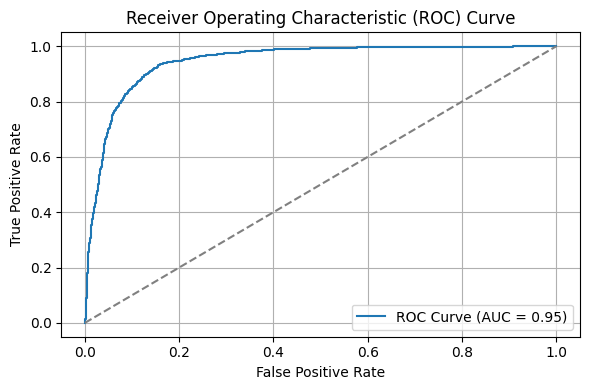

In [ ]:
y_proba = pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Get the encoded categorical feature names
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat'].named_steps['encoder']
ohe_features = ohe.get_feature_names_out(categorical_features)

# Combine numeric and encoded categorical names
all_features = list(numeric_features) + list(ohe_features)

### Feature Importance and SHAP Analysis

**Feature Importance (XGBoost Built-in Method):**
- Extracted feature importance scores from the trained XGBoost model.
- Top features: **ICULengthOfStay**, **Temperature**, **TimeSinceHospitalAdmission**, **WhiteBloodCellCount**, and **PatientAge**.
- These features contributed most to the model's predictive power.

**SHAP Analysis (SHapley Additive exPlanations):**
- Applied SHAP’s TreeExplainer for deeper interpretability.
- SHAP summary plot confirmed **ICULengthOfStay**, **Temperature**, and **TimeSinceHospitalAdmission** as key predictors.
- Higher ICU stays and higher temperatures were associated with increased sepsis risk.

**Conclusion**:  
Feature importance highlighted which features the model prioritized, while SHAP explained how they impacted predictions. Together, they confirmed that clinically logical variables strongly influenced sepsis risk, with higher values generally increasing the likelihood of sepsis.



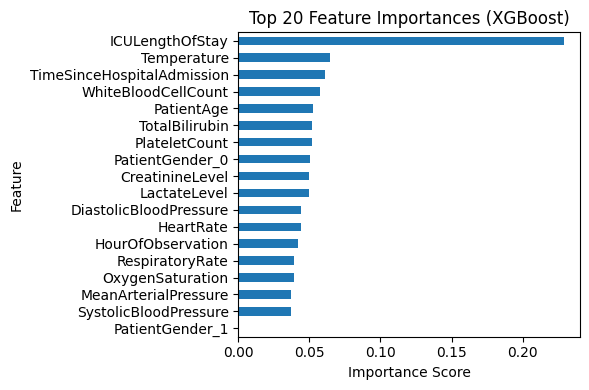

In [ ]:
# Get feature importances from the XGBoost model
importances = pipeline.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 4))
importance_df.head(20).set_index('Feature').Importance.plot(kind='barh')
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

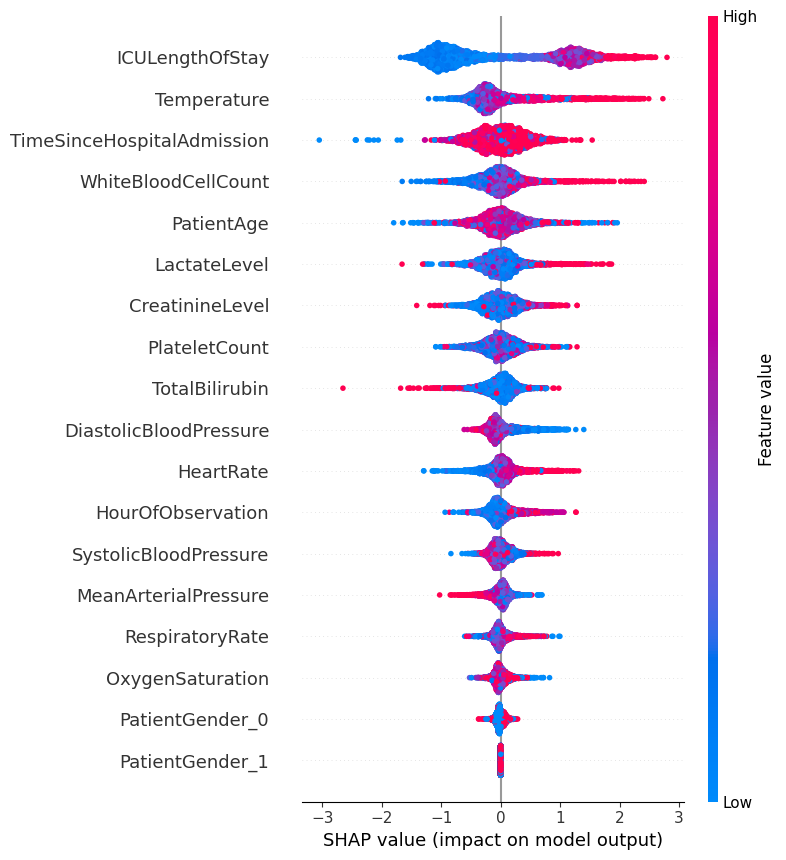

In [ ]:
X_sample = preprocessor.transform(X_test)

# Use TreeExplainer for XGBoost
explainer = shap.Explainer(pipeline.named_steps['classifier'])
shap_values = explainer(X_sample)

# SHAP summary plot
shap.summary_plot(shap_values, X_sample, feature_names=all_features)

### Sensitivity Analysis

Performed feature sensitivity analysis by systematically dropping one top feature at a time and retraining the model.

**Results:**
- Dropping **ICULengthOfStay**: Accuracy 90%, Recall 0.94, F1-score 0.91
- Dropping **Temperature**: Accuracy 90%, Recall 0.93, F1-score 0.91
- Dropping **WhiteBloodCellCount**: Accuracy 90%, Recall 0.93, F1-score 0.91
- Dropping **PatientAge**: Accuracy 89%, Recall 0.92, F1-score 0.89
- Dropping **LactateLevel**: Accuracy 89%, Recall 0.92, F1-score 0.89
- Dropping **CreatinineLevel**: Accuracy 89%, Recall 0.93, F1-score 0.90

**Conclusion:**  
The model's overall performance remained stable (accuracy around 89–90%) even after dropping individual top features. This suggests that the model is robust and not overly dependent on any single variable, although features like ICULengthOfStay, Temperature, and WhiteBloodCellCount contribute slightly more to predictive power.


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# List of top features to test sensitivity (based on SHAP)
top_features = [
    'ICULengthOfStay', 'Temperature', 'WhiteBloodCellCount', 'PatientAge',
    'LactateLevel', 'CreatinineLevel'
]

# Sensitivity loop: drop one feature at a time
for feature_to_drop in top_features:
    print(f"\nDropping feature: {feature_to_drop}")
    X = df_balanced.drop(columns=['SepsisIndicator', feature_to_drop]).fillna(0)
    y = df_balanced['SepsisIndicator']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))



Dropping feature: ICULengthOfStay


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:26:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1599
           1       0.87      0.94      0.91      1598

    accuracy                           0.90      3197
   macro avg       0.90      0.90      0.90      3197
weighted avg       0.90      0.90      0.90      3197


Dropping feature: Temperature


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:26:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1599
           1       0.88      0.93      0.91      1598

    accuracy                           0.90      3197
   macro avg       0.90      0.90      0.90      3197
weighted avg       0.90      0.90      0.90      3197


Dropping feature: WhiteBloodCellCount


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:26:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.93      0.88      0.90      1598
           1       0.88      0.93      0.91      1599

    accuracy                           0.90      3197
   macro avg       0.91      0.90      0.90      3197
weighted avg       0.91      0.90      0.90      3197


Dropping feature: PatientAge


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:26:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1598
           1       0.86      0.92      0.89      1599

    accuracy                           0.89      3197
   macro avg       0.89      0.89      0.89      3197
weighted avg       0.89      0.89      0.89      3197


Dropping feature: LactateLevel


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:26:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1598
           1       0.86      0.92      0.89      1599

    accuracy                           0.89      3197
   macro avg       0.89      0.89      0.89      3197
weighted avg       0.89      0.89      0.89      3197


Dropping feature: CreatinineLevel


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:26:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1599
           1       0.87      0.93      0.90      1598

    accuracy                           0.89      3197
   macro avg       0.90      0.89      0.89      3197
weighted avg       0.90      0.89      0.89      3197



### Other Models Performance Summary

The comparison of multiple machine learning models revealed clear differences in predictive performance based on Recall and F1-score, which are the most critical metrics for sepsis detection:

- **Extra Trees Classifier** achieved the highest performance, with a Recall of 93.8% and an F1-score of 92.3%, demonstrating both strong sensitivity and predictive reliability.
- **Random Forest Classifier** closely followed, with a Recall of 94.3% and an F1-score of 91.0%.
- **CatBoost** performed strongly as well, achieving a Recall of 86.4% and an F1-score of 84.4%.
- **K-Nearest Neighbors (KNN)** and **LightGBM** showed moderate performance, with Recall around 84–88% and F1-scores around 82–83%.
- **Gradient Boosting**, **Support Vector Machine (SVM)**, and **Calibrated SVM** delivered lower results, with Recall around 68–73% and F1-scores around 71–72%.
- **Logistic Regression**, **Linear Discriminant Analysis**, **Naive Bayes**, and **AdaBoost** underperformed, achieving Recall below 67% and notably lower F1-scores around 58–68%.

**Conclusion**  
When compared to the baseline XGBoost model, which achieved strong performance (Recall approximately 88%, F1-score approximately 89%), Extra Trees and Random Forest slightly outperformed XGBoost in terms of Recall and F1-score. However, XGBoost offers important advantages in computational efficiency, scalability to large datasets, and native handling of missing values. These operational strengths, combined with its strong predictive balance, make XGBoost a highly competitive and practical choice for clinical deployment.




In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, kernel='rbf', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Calibrated SVM": CalibratedClassifierCV(estimator=SVC(probability=False), method='sigmoid', cv=5),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

for name, model in models.items():
    clf = Pipeline([
        ('preprocess', preprocessor),
        ('classifier', model)
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Predict risk scores (probability of class 1)
    try:
        risk_scores = clf.predict_proba(X_test)[:, 1]
    except AttributeError:
        risk_scores = [0.5] * len(y_pred)  # fallback if predict_proba is not supported

    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("Precision:", round(precision_score(y_test, y_pred), 3))
    print("Recall:", round(recall_score(y_test, y_pred), 3))
    print("F1 Score:", round(f1_score(y_test, y_pred), 3))

    # Show sample risk scores
    print("# (Optional) also view a few sample risk scores")
    print("Example risk scores:", np.round(risk_scores[:10], 4))



Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.64      0.76      0.70      1998
           1       0.71      0.58      0.64      1998

    accuracy                           0.67      3996
   macro avg       0.68      0.67      0.67      3996
weighted avg       0.68      0.67      0.67      3996

Accuracy: 0.669
Precision: 0.707
Recall: 0.579
F1 Score: 0.636
# (Optional) also view a few sample risk scores
Example risk scores: [0.724  0.4278 0.5178 0.3625 0.6991 0.359  0.5231 0.4474 0.7062 0.3351]

Random Forest Results:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1998
           1       0.88      0.94      0.91      1998

    accuracy                           0.91      3996
   macro avg       0.91      0.91      0.91      3996
weighted avg       0.91      0.91      0.91      3996

Accuracy: 0.906
Precision: 0.878
Recall: 0.943
F1 Score: 0.91
# (Optional) also view a f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM Results:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1998
           1       0.80      0.84      0.82      1998

    accuracy                           0.82      3996
   macro avg       0.82      0.82      0.82      3996
weighted avg       0.82      0.82      0.82      3996

Accuracy: 0.817
Precision: 0.802
Recall: 0.841
F1 Score: 0.821
# (Optional) also view a few sample risk scores
Example risk scores: [0.9291 0.5499 0.3715 0.2327 0.8363 0.2416 0.5257 0.4295 0.7037 0.6024]

KNN Results:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      1998
           1       0.78      0.88      0.83      1998

    accuracy                           0.82      3996
   macro avg       0.82      0.82      0.82      3996
weighted avg       0.82      0.82      0.82      3996

Accuracy: 0.816
Precision: 0.781
Recall: 0.877
F1 Score: 0.826
# (Optional) also view a few sample risk score